In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
from linear_ssm import StateSpace_EM
from heteroscedastic_ssm import HeteroscedasticKalmanSmoother, HeteroscedasticStateSpace_EM

In [2]:
import factors, densities

In [3]:
def proj(U, v):
    return numpy.dot(numpy.dot(v, U) / numpy.linalg.norm(U, axis=0), U.T)

def gs(N):
    V = numpy.zeros((N, N))
    A = numpy.random.randn(N,N)
    #A = numpy.eye(N)
    for d in range(N):
        v = A[:,d]
        V[:,d] = v - proj(V[:,:d], v)
        V[:,d] /= numpy.sqrt(numpy.sum(V[:,d] ** 2))
    return V


def generate_heteroscedastic_data(T, Dx, Dz, Du, sigma_z = .2, sigma_x = .05):
    params_dict = {'T': T, 'Dx': Dx, 'Dz': Dz, 'Du': Du, 'sigma_z': sigma_z, 'sigma_x': sigma_x}
    C = numpy.random.randn(Dx, Dz) / .5
    U = gs(Dx)[:Du].T
    w = numpy.random.randn(Du, Dz)
    w /= .5 * numpy.sum(numpy.abs(w), axis=1)[:,None]
    b_w = 1. * numpy.random.randn(Du)
    beta = .1e-1 * numpy.random.rand(Du)
    params_dict = {**params_dict, 'C': C, 'U': U, 'w': w, 'b_w': b_w, 'beta': beta}
    
    # Sample latent space
    z = numpy.zeros([Dz, T])
    noise_z = sigma_z * numpy.random.randn(Dz, T)
    # A = .99 * numpy.eye(Dz)
    # A[1,0] = .05
    # A[0,1] = -.05
    # b = numpy.zeros(Dz)
    # for t in range(1,T):
    #     z[:,t] = numpy.dot(A, z[:,t-1]) + b + noise_z[:,t-1]
    freq = 1 / (1000 * numpy.random.rand(Dz) + 500)
    phase = 2 * numpy.pi * numpy.random.rand(Dz)
    for idz in range(Dz): 
        z[idz] = 5*numpy.cos(2 * numpy.pi * numpy.arange(T) * freq[idz] + phase[idz]) + noise_z[idz]
    D_Sigma = 2 * beta[:,None] * numpy.cosh(numpy.dot(w, z) + b_w[:,None])
    x = numpy.zeros((Dx,T))
    mu_x = numpy.dot(C, z)
    noise_x = numpy.random.randn(Dx, T)
    for t in range(T):
        Sigma_x = sigma_x ** 2 * numpy.eye(Dx) + numpy.dot(numpy.dot(U, numpy.diag(D_Sigma[:,t])), U.T)
        L_x = numpy.linalg.cholesky(Sigma_x)
        x[:,t] = mu_x[:,t] + numpy.dot(L_x, noise_x[:,t])
    return x, z, params_dict

Text(0, 0.5, 'z1')

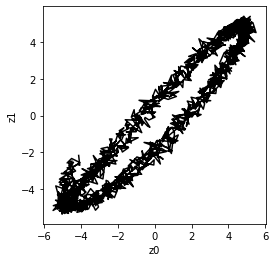

In [4]:
Dz = 3
Dx = 6
Du = 2
T = 2000
X, z, params_dict = generate_heteroscedastic_data(T, Dx, Dz, Du)
pyplot.figure(figsize=(4,4))
pyplot.plot(z[0], z[1], 'k')
pyplot.xlabel('z0')
pyplot.ylabel('z1')

Text(0, 0.5, 'X1')

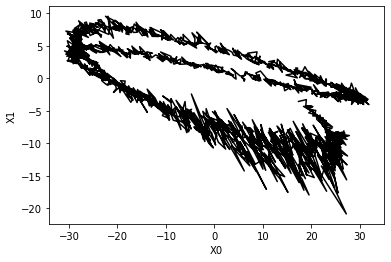

In [5]:
pyplot.plot(X[0], X[1], 'k')
pyplot.xlabel('X0')
pyplot.ylabel('X1')

In [6]:
A, b = numpy.eye(Dz), numpy.zeros(Dz)
C = params_dict['C']
d = numpy.zeros(Dx)
Qz = params_dict['sigma_z'] ** 2 * numpy.eye(Dz)
sigma_x = params_dict['sigma_x']
U = params_dict['U']
W = numpy.vstack([params_dict['b_w'], params_dict['w'].T])
beta = params_dict['beta']
hks = HeteroscedasticKalmanSmoother(X.T, A, b, Qz, C, d, U, W, beta, sigma_x)
hks.forward_path()
hks.backward_path()

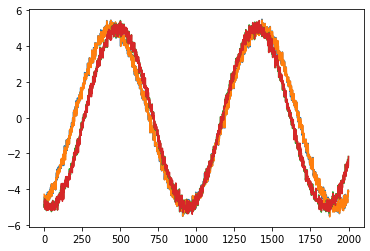

In [7]:
pyplot.plot(z.T[:,0])
pyplot.plot(hks.smoothing_density.mu[:,0])
pyplot.plot(z.T[:,1])
pyplot.plot(hks.smoothing_density.mu[:,1])

In [29]:
hssm = HeteroscedasticStateSpace_EM(X.T, Dz, Du)

In [30]:
hssm.run_em()

Iteration 1 - llk=-3398407.5
Iteration 2 - llk=-3397022.3
Iteration 3 - llk=-3396445.8
Iteration 4 - llk=-3396548.6


[-3398407.548540683,
 -3397022.2510372894,
 -3396445.7968125213,
 -3396548.6375765633]

In [106]:
hssm.get_lower_bounds()

In [52]:
hssm.W.shape, hssm.R_mat.shape, Dx

((4, 2), (2, 6, 6), 6)

In [57]:
numpy.sum(hssm.ks.smoothing_density.integrate('xx')[1:], axis=0)
#numpy.linalg.solve(hssm.Sigma_inv_zz, hssm.Sigma_inv_zx).T.shape, hssm.C.shape

array([[1031.30724811, 1926.77224685, -368.58193907],
       [1926.77224685, 5809.2540607 , -824.87024367],
       [-368.58193907, -824.87024367,  156.953945  ]])

In [89]:
A = numpy.sum(hssm.ks.smoothing_density.integrate('xx')[1:], axis=0) / hssm.ks.sigma_x ** 2 - hssm.Sigma_inv_zz
B = numpy.dot((hssm.ks.X - hssm.d).T, hssm.ks.smoothing_density.integrate('x')[1:])
B -= hssm.intD_inv_zx_d.T
numpy.linalg.solve(A, B.T).T

array([[-0.02291349, -0.02204157, -0.06375599],
       [ 0.01924827,  0.00789954,  0.0821896 ],
       [-0.01156744, -0.00600082, -0.07633127],
       [-0.00363307, -0.00259393, -0.03154073],
       [-0.01799849, -0.01619781, -0.09013523],
       [-0.01083863, -0.00791493, -0.05413191]])

In [107]:
hssm.update_d()

(1,) (1,)


In [104]:
hssm.intD_inv_x_Cz.shape, Du

((6,), 2)

In [10]:
hssm.compute_Q()

-8.919917243459418e+31

In [110]:
hssm.d

array([ 0.78908115, -1.99150163,  2.01261572,  0.8521397 ,  1.93452667,
        1.2314468 ])

In [28]:
import scipy
scipy.linalg.eigh(numpy.dot(X, X.T), eigvals=(hssm.Dx-hssm.Du, hssm.Dx-1))[1].shape

(6, 2)

In [94]:
Du

2

In [21]:
numpy.dot(hssm.U.T, hssm.U)

array([[1.00000000e+00, 1.33799292e-15],
       [1.33799292e-15, 1.00000000e+00]])

In [66]:
import scipy
scipy.linalg.eigh(hssm.R_mat[0], eigvals=(hssm.Dx-1,hssm.Dx-1))

(array([30935.97734228]),
 array([[-0.51254974],
        [-0.26659304],
        [-0.20113198],
        [-0.51995526],
        [-0.1492633 ],
        [-0.57717748]]))

In [110]:
U = numpy.eye(Dx)[:,:3]

In [121]:
U_not_i = numpy.delete(U, [1], axis=1)
V = hssm.partial_gs(U_not_i)

In [134]:
VRV = numpy.dot(numpy.dot(V.T, hssm.R_mat[0]), V)
alpha = scipy.linalg.eigh(VRV, eigvals=(VRV.shape[0]-1,VRV.shape[0]-1))[1]
u_new = numpy.dot(V, alpha)[0]


(6, 1)

In [40]:
hssm.compute_log_likelihood()

-40624037.6010447

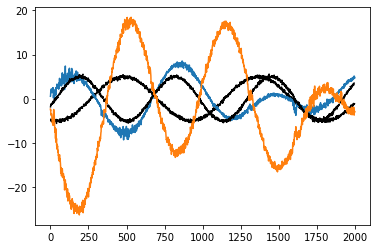

In [103]:
pyplot.plot(z.T[:,0], 'k--')
pyplot.plot(hssm.ks.smoothing_density.mu[:,0])
pyplot.plot(z.T[:,1], 'k--')
pyplot.plot(hssm.ks.smoothing_density.mu[:,1])